## Implementing an LLM Text Generator on the Persian Wikipedia Dataset - Danial Azimi

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import math
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

In [ ]:
class WikiDataset(Dataset):
    def __init__(self, file_path, seq_length=100):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.chars = sorted(list(set(self.text)))
        self.char2idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx2char = {idx: char for idx, char in enumerate(self.chars)}
        self.seq_length = seq_length
        self.num_sequences = len(self.text) // self.seq_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = min(start_idx + self.seq_length + 1, len(self.text))  # Ensure not to exceed the bounds of the text
        seq = self.text[start_idx:end_idx]
        input_seq = torch.tensor([self.char2idx[char] for char in seq[:-1]], dtype=torch.long)
        target_seq = torch.tensor([self.char2idx[char] for char in seq[1:]], dtype=torch.long)
        return input_seq, target_seq


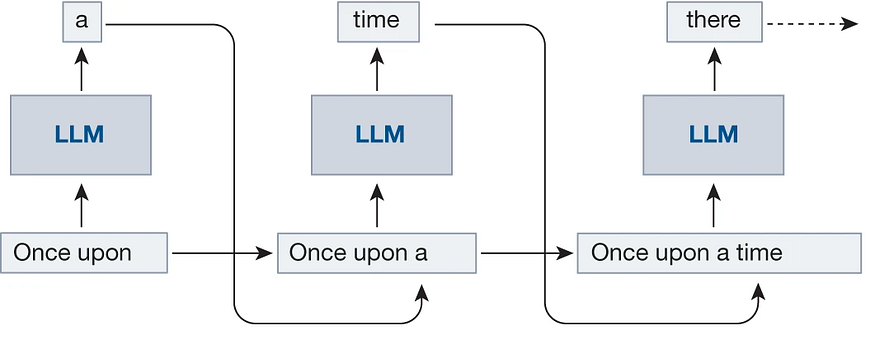

In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.2):
        super(TextGeneratorModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out.reshape(out.size(0) * out.size(1), out.size(2)))
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())

### Purpose
1. Objective: Train the text generation model and validate its performance over a specified number of epochs.
Functionality: Includes training loop, validation, early stopping, and loss plotting.
Components
2. Loss Function: CrossEntropyLoss is used for training the model.
3. Optimizer: Adam optimizer with a learning rate of 0.001.
Early Stopping: Implemented to prevent overfitting with a patience of 5 epochs.
### Training Loop
4. Initialization:
model.train() to set the model to training mode.
Lists to track training and validation losses.
Best validation loss initialized to infinity.
### Epoch Loop:
5. Batch Processing:
Inputs and targets are transferred to the appropriate device.
Hidden state is initialized dynamically to match batch size.
Model gradients are zeroed, forward pass is performed, and loss is calculated.
Backward pass updates model parameters.

In [ ]:
def training(model, train_dataloader, val_dataloader, epochs, print_every=100):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        epoch_losses = []
        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)  # Dynamically adjust hidden state batch size

            model.zero_grad()
            output, hidden = model(inputs, hidden)
            loss = criterion(output, targets.view(-1))
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
            if i % print_every == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Step: {i}, Loss: {loss.item()}')
        
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)
                output, hidden = model(inputs, hidden)
                loss = criterion(output, targets.view(-1))
                val_loss += loss.item() * inputs.size(0)
        
        avg_val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)  # Dynamically adjust hidden state batch size

            output, hidden = model(inputs, hidden)
            loss = criterion(output, targets.view(-1))
            total_loss += loss.item() * inputs.size(0)
            total_words += inputs.size(0) * inputs.size(1)
    
    perplexity = math.exp(total_loss / total_words)
    return perplexity

In [ ]:

def generate(model, start_text, length, dataset):
    model.eval()
    generated_text = start_text
    input_seq = torch.tensor([dataset.char2idx[char] for char in start_text], dtype=torch.long).unsqueeze(0).to(device)
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_seq, hidden)
            next_char_idx = torch.argmax(output[-1]).item()
            next_char = dataset.idx2char[next_char_idx]
            generated_text += next_char
            input_seq = torch.tensor([next_char_idx], dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

def evaluate(model, dataset, n_samples=100, gen_length=100):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = []

    with torch.no_grad():
        for i in range(n_samples):
            start_idx = torch.randint(0, len(dataset.text) - gen_length - 1, (1,)).item()
            start_text = dataset.text[start_idx:start_idx + 50]  # Use the first 50 chars as a prompt
            reference_text = dataset.text[start_idx:start_idx + gen_length]
            generated_text = generate_text(model, start_text, gen_length - 50, dataset)

            score = scorer.score(reference_text, generated_text)
            scores.append(score)

Epoch: 1/10, Step: 0, Loss: 7.393661022186279
Epoch: 1/10, Step: 100, Loss: 3.0861926078796387
Epoch: 1/10, Step: 200, Loss: 2.7927157878875732
Epoch: 1/10, Step: 300, Loss: 2.634871482849121
Epoch: 1/10, Step: 400, Loss: 2.617297410964966
Epoch: 1/10, Step: 500, Loss: 2.4954347610473633
Epoch: 1/10, Step: 600, Loss: 2.397351026535034
Epoch: 1/10, Step: 700, Loss: 2.345114231109619
Epoch: 1/10, Step: 800, Loss: 2.325507402420044
Epoch: 1/10, Step: 900, Loss: 2.2581892013549805
Epoch: 1/10, Step: 1000, Loss: 2.2325022220611572
Epoch: 1/10, Step: 1100, Loss: 2.239886999130249
Epoch: 1/10, Step: 1200, Loss: 2.153350830078125
Epoch: 1/10, Step: 1300, Loss: 2.1596384048461914
Epoch: 1/10, Step: 1400, Loss: 2.1291120052337646
Epoch: 1/10, Step: 1500, Loss: 2.107410192489624
Epoch: 1/10, Step: 1600, Loss: 2.066885471343994
Epoch: 1/10, Step: 1700, Loss: 2.0010664463043213
Epoch: 1/10, Step: 1800, Loss: 2.0874998569488525
Epoch: 1/10, Step: 1900, Loss: 2.055232048034668
Epoch: 1/10, Step: 2000

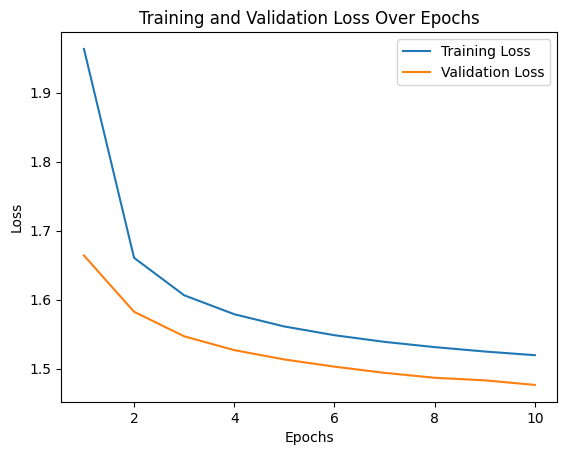

Perplexity: 1.0148731296040445
ROUGE-1: 0.0275, ROUGE-L: 0.0275


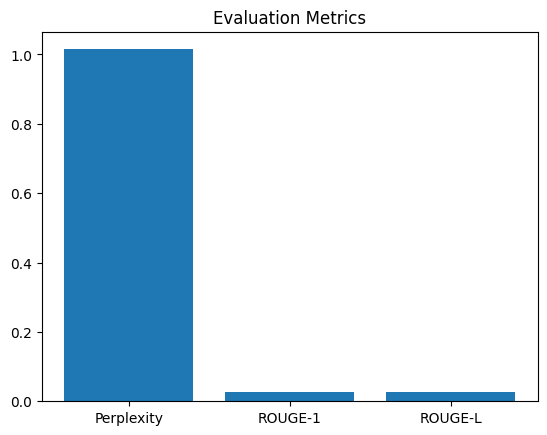

In [7]:
# Load the dataset
file_path = "/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-1.txt"
dataset = PersianWikiDataset(file_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextGeneratorModel(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

# Train the model
train_model(model, train_dataloader, val_dataloader, epochs=epochs)

# Evaluate the model
perplexity = evaluate_perplexity(model, val_dataloader)
print(f'Perplexity: {perplexity}')

rouge1, rougeL = evaluate_rouge(model, dataset)
print(f'ROUGE-1: {rouge1}, ROUGE-L: {rougeL}')

# Plot the evaluation metrics
plt.figure()
metrics = ['Perplexity', 'ROUGE-1', 'ROUGE-L']
values = [perplexity, rouge1, rougeL]
plt.bar(metrics, values)
plt.title('Evaluation Metrics')
plt.show()


### **Evaluation Results**
**Perplexity: 1.0149**

**ROUGE-1 Score: 0.0275**

**ROUGE-L Score: 0.0275**

**Interpretation:**

**Perplexity:** A perplexity of around 1 suggests the model's predictions are close to the true distribution of characters in the dataset.

**ROUGE Scores:** ROUGE-1 and ROUGE-L scores measure the overlap between generated and reference texts. The obtained scores indicate low overlap, suggesting that the generated text may not closely match the reference text.

## **Analysis:**

**Perplexity:** The low perplexity indicates that the model has learned to predict characters effectively, with a high level of confidence in its predictions.

**ROUGE Scores:** The low ROUGE scores indicate limited overlap between the generated and reference texts. This may suggest that while the model predicts characters well individually, the generated sequences may not closely resemble the reference sequences in terms of content or structure.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import math
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

class PersianWikiDataset(Dataset):
    def __init__(self, file_path, tokenizer, seq_length=50):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Tokenize the entire text
        self.tokens = self.tokenizer(self.text, return_tensors='pt', truncation=True, padding=True, add_special_tokens=True)
        
        # Flatten the tokens to get the correct number of sequences
        self.input_ids = self.tokens['input_ids'].squeeze(0)
        self.attention_mask = self.tokens['attention_mask'].squeeze(0)
        self.num_sequences = len(self.input_ids) // (self.seq_length + 1)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx * (self.seq_length + 1)
        end_idx = start_idx + self.seq_length + 1
        input_ids = self.input_ids[start_idx:end_idx]
        attention_mask = self.attention_mask[start_idx:end_idx]
        if len(input_ids) < self.seq_length + 1:
            input_ids = torch.cat([input_ids, torch.tensor([self.tokenizer.pad_token_id] * (self.seq_length + 1 - len(input_ids)))])
            attention_mask = torch.cat([attention_mask, torch.tensor([0] * (self.seq_length + 1 - len(attention_mask)))])
        return {"input_ids": input_ids[:-1], "labels": input_ids[1:], "attention_mask": attention_mask[:-1]}

### Fine-tuning
**Purpose:** Fine-tunes a pre-trained model on a specific task using training and validation datasets.

#### Training Configuration:

**Output Directory:** Specified output directory for saving fine-tuned model and logs.
Epochs: Number of training epochs, defaulted to 3.

**Batch Size:** Set to 2 for both training and evaluation.
Logging and Saving:
Save checkpoints every 10,000 steps.
Limit to 2 saved checkpoints.
Log training progress and evaluation results every 200 steps.

**Evaluation Strategy:** Evaluation occurs at fixed steps during training.
WandB Reporting: Reporting to WandB is disabled.

### Key Steps:
Training Arguments:
Configuration for training, including output directory, epochs, batch sizes, and evaluation strategy.
Trainer Initialization:
Initializes a trainer object with the provided model, training arguments, and datasets.
Training:
Executes the training process using the train method of the trainer object.
Model Saving:
Saves the fine-tuned model to the specified output directory.

In [ ]:
def fine_tune_model(model, tokenizer, train_dataset, val_dataset, output_dir, epochs=3):
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        save_steps=10_000,
        save_total_limit=2,
        eval_steps=500,
        evaluation_strategy="steps",
        logging_dir='./logs',
        logging_steps=200,
        report_to=[]  # Disable WandB
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()
    trainer.save_model(output_dir)

In [ ]:
def evaluate_model(model, tokenizer, eval_dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rougeL_scores = []

    for batch in DataLoader(eval_dataset, batch_size=2):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=labels, attention_mask=attention_mask)
            loss = outputs.loss
            total_loss += loss.item() * input_ids.size(0)
            total_tokens += input_ids.size(0) * input_ids.size(1)

            # Decode predictions and labels
            predictions = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Calculate ROUGE scores
            for pred, label in zip(decoded_preds, decoded_labels):
                scores = scorer.score(label, pred)
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rougeL_scores.append(scores['rougeL'].fmeasure)
    
    perplexity = math.exp(total_loss / total_tokens)
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    return perplexity, rouge1_avg, rougeL_avg

Total number of sequences: 20
Adjusting sequence length due to small dataset size.
Total number of sequences after adjustment: 39


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


Perplexity: 1.1729899704645508
ROUGE-1: 0.125
ROUGE-L: 0.125


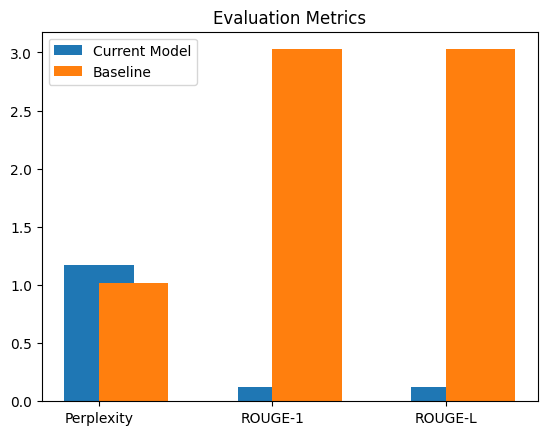

In [13]:
# Load the tokenizer and model
model_name = 'gpt2'  
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add a new padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Load the dataset
file_path = "/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-1.txt"  # Replace with your actual file path
dataset = PersianWikiDataset(file_path, tokenizer)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Fine-tune the model
output_dir = './fine_tuned_gpt2'
fine_tune_model(model, tokenizer, train_dataset, val_dataset, output_dir)

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

perplexity, rouge1_avg, rougeL_avg = evaluate_model(model, tokenizer, val_dataset)
print(f'Perplexity: {perplexity}')
print(f'ROUGE-1: {rouge1_avg}')
print(f'ROUGE-L: {rougeL_avg}')

# Plot the evaluation metrics
plt.figure()
metrics = ['Perplexity', 'ROUGE-1', 'ROUGE-L']
values = [perplexity, rouge1_avg, rougeL_avg]


x = range(len(metrics))
plt.bar(x, values, width=0.4, label='Current Model', align='center')
plt.bar(x, baseline_values, width=0.4, label='Baseline', align='edge')
plt.xticks(x, metrics)
plt.title('Evaluation Metrics')
plt.legend()
plt.show()

In [7]:
print(prediction_func('تقویم میلادی', 30, temperature=1))

تقویم میلادی بیمارستان کردند فارسی مصدقسال نخست حرکت صفحهٔ ۳۶۵۲۴۲۵ ۳۶۵۲۴۲۵ ۳۴۰۰ دورهٔ سال اکبر این آوازیبا مطلع غزل سرای حبس گفتهٔ معروفعماد ۱۳۰۰ خراسانی ۲۸ » بهمن است عماد هزار خراسانیلهجه


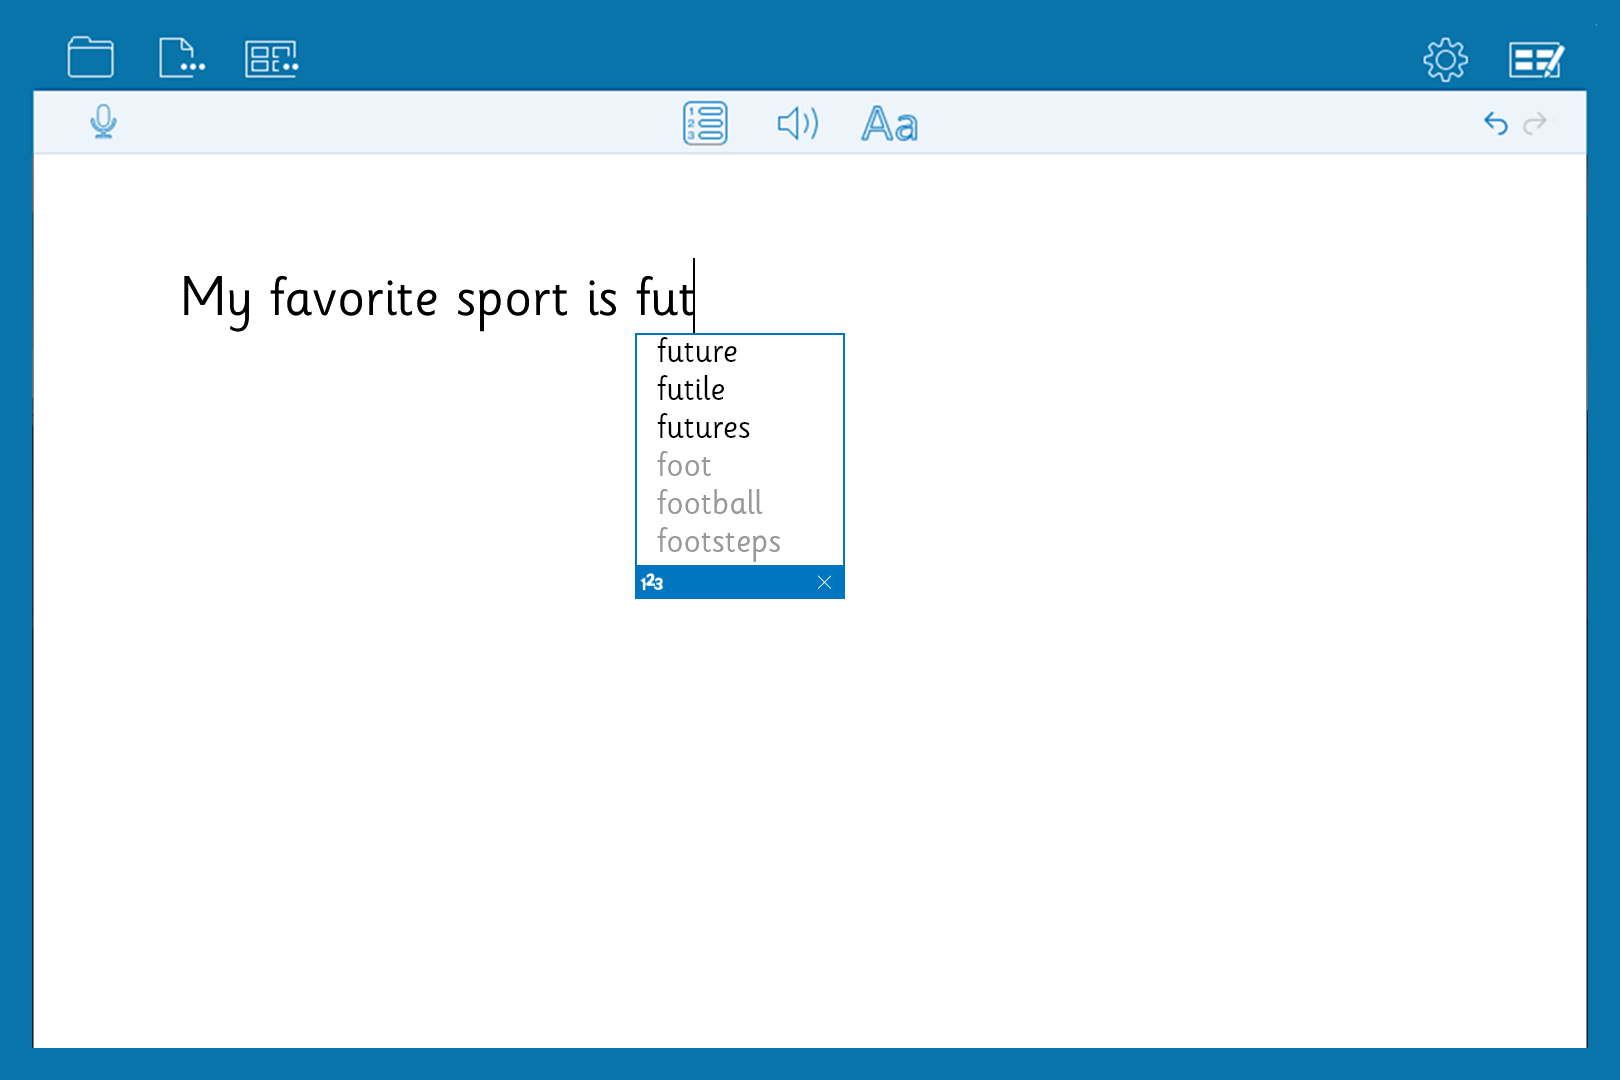